In [76]:
import torch
import lzma
from itertools import islice
import re
import sys
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
from torch.utils.data import IterableDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

In [77]:
VOCAB_SIZE = 10_000
EMBED_SIZE = 400

In [78]:
def get_words_from_line(line):
  line = line.rstrip()
  line = line.split("\t")
  text = line[-2] + " " + line[-1]
  text = re.sub(r"\\+n", " ", text)
  text = re.sub('[^A-Za-z ]+', '', text)
  for t in text.split():
    yield t

def get_word_lines_from_file(file_name):
  with lzma.open(file_name, encoding='utf8', mode="rt") as fh:
    for line in fh:
       yield get_words_from_line(line)

vocab = build_vocab_from_iterator(
    get_word_lines_from_file("train/in.tsv.xz"),
    max_tokens = VOCAB_SIZE,
    specials = ['<unk>'])

KeyboardInterrupt: 

In [ ]:
def look_ahead_iterator(gen):
   first = None
   second = None
   for item in gen:
      if first is not None and second is not None:
         yield ((first, item), second)
      first = second
      second = item

class Trigrams(IterableDataset):
  def __init__(self, text_file, vocabulary_size):
      self.vocab = vocab
      self.vocab.set_default_index(self.vocab['<unk>'])
      self.vocabulary_size = VOCAB_SIZE
      self.text_file = text_file

  def __iter__(self):
     return look_ahead_iterator(
         (self.vocab[t] for t in itertools.chain.from_iterable(get_word_lines_from_file(self.text_file))))

train_dataset = Trigrams("train/in.tsv.xz", VOCAB_SIZE)

In [ ]:
class TrigramNNModel(nn.Module):
  def __init__(self, VOCAB_SIZE, EMBED_SIZE):
      super(TrigramNNModel, self).__init__()
      self.embeddings = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
      self.hidden_layer = nn.Linear(EMBED_SIZE*2, 1200)
      self.output_layer = nn.Linear(1200, VOCAB_SIZE)
      self.softmax = nn.Softmax()

  def forward(self, x):
      emb_2 = self.embeddings(x[0])
      emb_1 = self.embeddings(x[1])
      x = torch.cat([emb_2, emb_1], dim=1)
      x = self.hidden_layer(x)
      x = self.output_layer(x)
      x = self.softmax(x)
      return x

model = TrigramNNModel(vocab_size, embed_size)

vocab.set_default_index(vocab['<unk>'])

In [ ]:
device = 'cpu'
model = TrigramNNModel(VOCAB_SIZE, EMBED_SIZE).to(device)
data = DataLoader(train_dataset, batch_size=2_000)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.NLLLoss()

loss_track = []
last_loss = 1_000
trigger_count = 0

model.train()
step = 0
for x, y in data:
   x[0] = x[0].to(device)
   x[1] = x[1].to(device)
   y = y.to(device)
   optimizer.zero_grad()
   ypredicted = model(x)
   loss = criterion(torch.log(ypredicted), y)
   if step % 100 == 0:
      print(step, loss)
   step += 1
   loss.backward()
   optimizer.step()

   if loss > last_loss:
      trigger_count += 1 
      print(trigger_count, 'LOSS DIFF:', loss, last_loss)

   if trigger_count >= 500:
      break

   loss_track.append(loss)
   last_loss = loss

C:\Users\micha\AppData\Local\Temp\ipykernel_14016\2809838665.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


0 tensor(9.2713, grad_fn=<NllLossBackward0>)
1 LOSS DIFF: tensor(8.2370, grad_fn=<NllLossBackward0>) tensor(8.2154, grad_fn=<NllLossBackward0>)
2 LOSS DIFF: tensor(8.0085, grad_fn=<NllLossBackward0>) tensor(7.9711, grad_fn=<NllLossBackward0>)
3 LOSS DIFF: tensor(8.0149, grad_fn=<NllLossBackward0>) tensor(8.0085, grad_fn=<NllLossBackward0>)
4 LOSS DIFF: tensor(7.5328, grad_fn=<NllLossBackward0>) tensor(7.4404, grad_fn=<NllLossBackward0>)
5 LOSS DIFF: tensor(7.5367, grad_fn=<NllLossBackward0>) tensor(7.5328, grad_fn=<NllLossBackward0>)
6 LOSS DIFF: tensor(7.6733, grad_fn=<NllLossBackward0>) tensor(7.5367, grad_fn=<NllLossBackward0>)
7 LOSS DIFF: tensor(7.4703, grad_fn=<NllLossBackward0>) tensor(7.3663, grad_fn=<NllLossBackward0>)
8 LOSS DIFF: tensor(7.2923, grad_fn=<NllLossBackward0>) tensor(7.1224, grad_fn=<NllLossBackward0>)
9 LOSS DIFF: tensor(7.2912, grad_fn=<NllLossBackward0>) tensor(7.0721, grad_fn=<NllLossBackward0>)
10 LOSS DIFF: tensor(7.4529, grad_fn=<NllLossBackward0>) tensor(

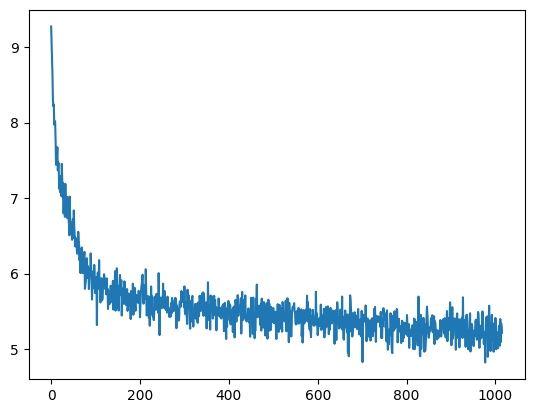

In [ ]:
plt.plot([t.detach().numpy() for t in loss_track])
plt.show()

In [ ]:
torch.save(model.state_dict(), f'model_trigram-EMBED_SIZE={EMBED_SIZE}.bin')

In [ ]:
vocab_unique = set(vocab.get_stoi().keys())

In [ ]:
output = []
with lzma.open("dev-0/in.tsv.xz", encoding='utf8', mode="rt") as file:
    for line in file:
        line = line.split("\t")

        first_word = re.sub(r"\\+n", " ", line[-2]).split()[-1]
        first_word = re.sub('[^A-Za-z]+', '', first_word)

        second_word = re.sub(r"\\+n", " ", line[-1]).split()[0]
        second_word = re.sub('[^A-Za-z]+', '', second_word)

        if first_word not in vocab_unique:
            word = "<unk>"
        if second_word not in vocab_unique:
            word = "<unk>"

        input_tokens = torch.tensor([vocab.forward([first_word]), vocab.forward([second_word])]).to(device)
        out = model(input_tokens)

        top = torch.topk(out[0], 10)
        top_indices = top.indices.tolist()
        top_probs = top.values.tolist()
        unk_bonus = 1 - sum(top_probs)
        top_words = vocab.lookup_tokens(top_indices)
        top_zipped = list(zip(top_words, top_probs))

        res = ""
        for w, p in top_zipped:
            if w == "<unk>":
                res += f":{(p + unk_bonus):.4f} "
            else:
                res += f"{w}:{p:.4f} "
        
        res = res[:-1]
        res += "\n"
        output.append(res)

with open(f"dev-0/out-EMBED_SIZE={EMBED_SIZE}.tsv", mode="w") as file:
    file.writelines(output)

C:\Users\micha\AppData\Local\Temp\ipykernel_14016\2809838665.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [ ]:
model.eval()

output = []
with lzma.open("test-A/in.tsv.xz", encoding='utf8', mode="rt") as file:
    for line in file:
        line = line.split("\t")

        first_word = re.sub(r"\\+n", " ", line[-2]).split()[-1]
        first_word = re.sub('[^A-Za-z]+', '', first_word)

        second_word = re.sub(r"\\+n", " ", line[-1]).split()[0]
        second_word = re.sub('[^A-Za-z]+', '', second_word)

        if first_word not in vocab_unique:
            word = "<unk>"
        if second_word not in vocab_unique:
            word = "<unk>"

        input_tokens = torch.tensor([vocab.forward([first_word]), vocab.forward([second_word])]).to(device)
        out = model(input_tokens)

        top = torch.topk(out[0], 10)
        top_indices = top.indices.tolist()
        top_probs = top.values.tolist()
        unk_bonus = 1 - sum(top_probs)
        top_words = vocab.lookup_tokens(top_indices)
        top_zipped = list(zip(top_words, top_probs))

        res = ""
        for w, p in top_zipped:
            if w == "<unk>":
                res += f":{(p + unk_bonus):.4f} "
            else:
                res += f"{w}:{p:.4f} "
        
        res = res[:-1]
        res += "\n"
        output.append(res)

with open(f"test-A/out-EMBED_SIZE={EMBED_SIZE}.tsv", mode="w") as file:
    file.writelines(output)

C:\Users\micha\AppData\Local\Temp\ipykernel_14016\2809838665.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
